#**Customer Segmentation Analysis : Online Retail Dataset**

---
by Dhiaa Grar

Customer segmentation is a powerful technique used to divide customers into distinct groups based on shared characteristics, allowing businesses to better understand their behavior and preferences. In this project, we will analyze patterns in the *Online Retail Data Set* from the UCI Machine Learning Repository. Our goal is to segment customers into specific groups using the **RFM (Recency, Frequency, Monetary)** principle. By using this method, we aim to uncover meaningful insights that can help optimize marketing strategies, enhance customer engagement, and drive business growth. This approach allows us to categorize customers based on their recent purchasing behavior, frequency of purchases, and the monetary value of their transactions.

The dataset we will be working with is a transactional dataset that records all transactions between ***December 1, 2010***, and ***December 9, 2011***, for a UK-based and registered non-store online retailer. The company primarily specializes in selling unique, all-occasion gifts. A significant portion of its customer base consists of wholesalers.

The dataset consists of **541,909** entries and includes **eight columns**, six of which serve as key features for analysis. These columns are:  

- **InvoiceNo**: A six-digit unique identifier for each transaction. If the invoice number starts with the letter *'C'*, it indicates a canceled transaction.  
- **StockCode**: A five-digit unique identifier assigned to each distinct product.  
- **Description**: The name or description of the product.  
- **Quantity**: The number of units of each product purchased per transaction.  
- **InvoiceDate**: The timestamp indicating when the transaction occurred.  
- **UnitPrice**: The price of a single unit of the product.  
- **CustomerID**: A five-digit unique identifier assigned to each customer.  
- **Country**: The country where the customer is located.  

This dataset provides valuable transactional insights, making it well-suited for customer segmentation analysis.


## **Importing the dataset**

In [ ]:
import pandas as pd

excel_file_path = '/content/drive/MyDrive/Online Retail.xlsx'
sheet_name = 'Online Retail'

df = pd.read_excel(excel_file_path, sheet_name=sheet_name)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


## **Data Cleaning and Preparation**

Before proceeding with the analysis, we first ensure that the dataset has been fully loaded by verifying its total number of records. Since the dataset contains 541,909 entries, we check the length of the dataframe to confirm that all records are present:

In [ ]:
num_rows = len(df)
num_rows

541909

To ensure data accuracy and prevent misleading insights, we remove any duplicate records from the dataset. We achieve this by using the `drop_duplicates`() function:

In [ ]:
df = df.drop_duplicates()
num_rows = len(df)
num_rows

536641

After removing duplicates, the dataset was reduced by 5,268 records, confirming that all removed entries were duplicates.

Next, we check for null values to identify any missing data that could affect our analysis.

In [ ]:
null_counts = df.isnull().sum()
null_counts

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135037
Country,0


The only columns containing null values are *Description* and *CustomerID*. The missing values in the *Description* column will not impact our analysis, as this feature is not required for our segmentation process. However, the *CustomerID* column is essential for our analysis, as it serves as the basis for customer segmentation. Transactions without a *CustomerID* cannot be linked to specific customers, making them unusable for our study. Therefore, we remove all records where *CustomerID* is missing to ensure the accuracy and relevance of our analysis.

In [ ]:
df = df.dropna(subset=['CustomerID'])
num_rows = len(df)
num_rows

401604

After removing records with missing CustomerID, the dataset was reduced by 135,037 entries. We now have a cleaned dataset containing 401,604 records, which is ready for the next steps in our customer segmentation analysis.

## **Building RFM metrics**
  
The **RFM (Recency, Frequency, Monetary)** approach is a customer segmentation technique used to analyze purchasing behavior. It evaluates customers based on:  
- **Recency (R):** How recently a customer made a purchase.  
- **Frequency (F):** How often a customer makes purchases.  
- **Monetary (M):** The total amount a customer has spent.  

This method helps businesses identify high-value customers and tailor marketing strategies accordingly.In this customer segmentation project, we will use the **RFM method** to categorize customers based on their purchasing behavior.

Since transactions with negative values in the *Quantity* column indicate cancellations, they cannot be removed, as they are essential for accurately calculating a customer's monetary value. It is stated that all cancellation invoices have an *InvoiceNo* that starts with the letter **'C'**. To verify this, we first check whether all cancellation transactions contain only negative quantities and all start with 'C'.


In [ ]:
Cancellations = df.groupby('InvoiceNo')['Quantity'].apply(lambda x: (x < 0).all())
Cancellations = Cancellations[Cancellations].index.tolist()

all_start_with_C = all(element.startswith('C') for element in Cancellations)
print(all_start_with_C)

True


We will build an **RFM table** that includes all customers in the dataset, incorporating three key features: **Recency, Frequency, and Monetary Value**. Each feature will be extracted as follows:  

- **Recency & Frequency:** To ensure accuracy, we use a filtered dataset where cancellation transactions are removed. This prevents misleading values in these two features. Recency is calculated as the number of days since a customer’s last purchase, measured from *December 10, 2011*—the day after the last recorded transaction in the dataset. Frequency is determined by counting the number of unique *InvoiceNo* values associated with each customer, reflecting how often they make purchases.

- **Monetary Value:** Unlike the other two features, we retain the original dataset, including cancellations, to accurately compute the total amount each customer has spent. Monetary Value is computed by first creating a new column, *Total_Amount*, which represents the total spending per transaction. This is obtained by multiplying the *Quantity* of products purchased by their respective *UnitPrice*. The total monetary value for each customer is then calculated by summing up all *Total_Amount* values corresponding to that customer.  

The process consists of three steps:  
1. Constructing a **Recency & Frequency** table using the `groupby()` function on the filtered dataset, aggregating data by **CustomerID**.  
2. Creating a **Monetary Value** table using the same method but applied to the original dataset.  
3. Merging the two tables using the `join()` function to form the final **RFM dataframe**, containing all customers and their corresponding **Recency, Frequency, and Monetary** values.

In [ ]:
import datetime as dt

reference_date = dt.datetime(2011, 12, 10)
df['total_amount'] = df['Quantity'] * df['UnitPrice']

filtered_df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

rfm_freq_recency = filtered_df.groupby('CustomerID').agg({

    'InvoiceDate': lambda x: (reference_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique'  # Frequency
})

rfm_monetary = df.groupby('CustomerID')['total_amount'].sum()  # Monetary

rfm = rfm_freq_recency.join(rfm_monetary, on='CustomerID')

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'total_amount': 'Monetary'
}, inplace=True)

print(rfm.head())

print('The number of customers is',len(rfm))

            Recency  Frequency  Monetary
CustomerID                              
12346.0         325          1      0.00
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          18          1   1757.55
12350.0         310          1    334.40
The number of customers is 4339


After constructing the RFM dataframe with **4,339 customers** and their corresponding features, we need to check for customers with **negative monetary values**. Such cases indicate that these customers may have canceled previous purchases that are not reflected within the timeframe of our dataset.  

Since these customers could misrepresent customer spending behavior, they must be removed from the RFM dataframe to ensure accuracy and consistency in our segmentation process.

In [ ]:
negative_monetary_values = rfm[rfm['Monetary'] < 0]

if not negative_monetary_values.empty:
    print("Negative values found in the 'Monetary' column:")
    print(negative_monetary_values)
else:
    print("No negative values found in the 'Monetary' column.")

Negative values found in the 'Monetary' column:
            Recency  Frequency      Monetary
CustomerID                                  
13672.0         301          2 -7.146000e+01
14437.0         365          1 -4.340000e+01
15802.0         142          1 -4.514200e+02
15823.0         372          1 -8.407600e+02
16454.0          44          2 -8.150000e+00
16546.0         290          2 -9.593000e+01
17548.0         233          1 -1.414800e+02
17603.0          78          1 -1.165300e+03
18072.0         185          1 -5.329071e-15


In [ ]:
rfm = rfm[rfm['Monetary'] >= 0]

print('The number of customers is',len(rfm))

The number of customers is 4330


After removing **9 customers** with negative monetary values, the final RFM table is complete, leaving us with **4,330 customers** ready for segmentation.  Now, we can proceed with clustering these customers based on their **Recency, Frequency, and Monetary** scores.

In [ ]:
rfm.describe()

,Recency,Frequency,Monetary
count,4330.000000,4330.000000,4330.000000
mean,91.768591,4.278060,1914.953479
std,99.800172,7.712302,8255.262801
min,0.000000,1.000000,0.000000
25%,17.000000,1.000000,299.395000
50%,50.000000,2.000000,652.570000
75%,141.000000,5.000000,1623.922500
max,373.000000,210.000000,279489.020000


##**Creating RFM Score**

The next step is to assign scores to each RFM metric, allowing us to categorize customers based on their purchasing behavior. Each customer will receive a score for **Recency, Frequency, and Monetary Value**, using a scale of **1 to 4**:  

- **Recency (R):** Customers who purchased recently will receive a score of **4**, while those who haven’t purchased in a long time will get **1**.  
- **Frequency (F):** Customers who have made the most purchases will receive a score of **4**, while those with fewer transactions will get **1**.  
- **Monetary Value (M):** The highest spenders will be assigned **4**, while those who spent the least will receive **1**.  

Once individual scores are assigned, we combine the three metrics into a **three-digit RFM score** (e.g., **441**, **312**, etc.), which provides a structured way to classify customers based on their overall engagement and value.

In [ ]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

##**Segmenting Customers**

After generating RFM scores for all customers, the final step is to assign them to segments based on whether they have high or low values for Recency (R), Frequency (F), and Monetary (M). We create **8 distinct segments**, corresponding to all possible combinations of high or low values across the three features.

A *Segment* column is added to the RFM dataframe, assigning each customer to the appropriate category based on their RFM score.

In [ ]:
segmentation_map = {
    r'[3-4][3-4][3-4]': 'Champions',  # High R, F, M
    r'[3-4][1-2][3-4]': 'Promising Big Spenders',  # High R, Low F, High M
    r'[3-4][3-4][1-2]': 'Loyal Budget Buyers',  # High R, High F, Low M
    r'[1-2][3-4][3-4]': 'At-Risk High-Value',  # Low R, High F, High M
    r'[1-2][1-2][3-4]': 'Lost Big Spenders',  # Low R, Low F, High M
    r'[1-2][3-4][1-2]': 'At-Risk Budget Buyers',  # Low R, High F, Low M
    r'[3-4][1-2][1-2]': 'New Budget Buyers',  # High R, Low F, Low M
    r'[1-2][1-2][1-2]': 'Lost Low-Value'  # Low R, Low F, Low M
}

rfm['Segment'] = rfm['RFM_Score'].replace(segmentation_map, regex=True)

print(rfm.head(20))

            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score  \
CustomerID                                                                   
12346.0         325          1      0.00       1       1       1       111   
12347.0           2          7   4310.00       4       4       4       444   
12348.0          75          4   1797.24       2       3       4       234   
12349.0          18          1   1757.55       3       1       4       314   
12350.0         310          1    334.40       1       1       2       112   
12352.0          36          8   1545.41       3       4       3       343   
12353.0         204          1     89.00       1       1       1       111   
12354.0         232          1   1079.40       1       1       3       113   
12355.0         214          1    459.40       1       1       2       112   
12356.0          22          3   2811.43       3       2       4       324   
12357.0          33          1   6207.67       3       1       4

## **Exploring Segments**
Now that we have successfully segmented our customers, we will visualize the distribution of these segments using a **bar chart**. This chart will display each customer segment along with the number of customers it contains, allowing us to identify which clusters are the most prevalent.

<ipython-input-14-97bcc94e9fe3>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


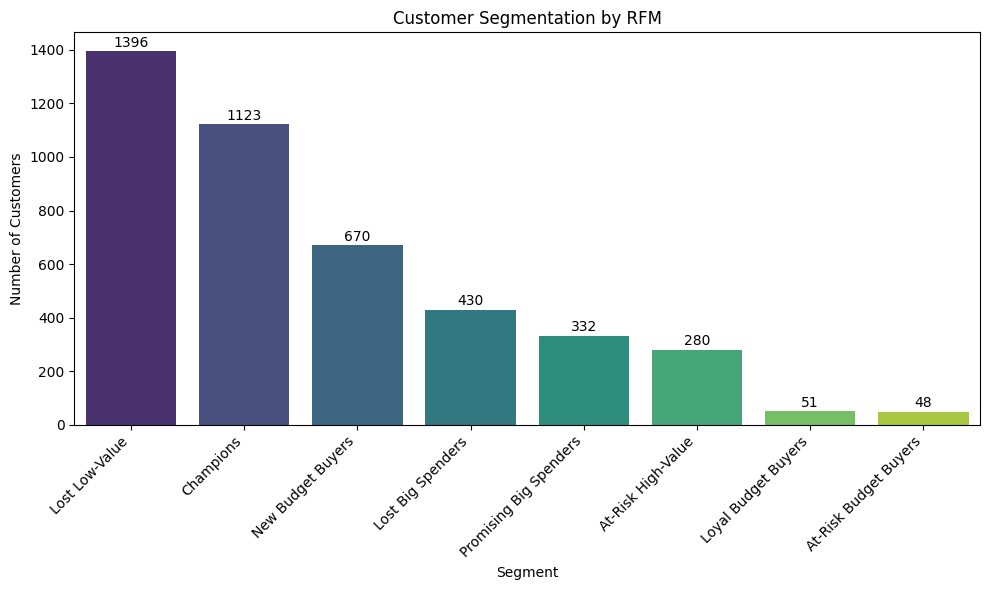

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')

plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Segmentation by RFM')
plt.xticks(rotation=45, ha='right')

for i, count in enumerate(segment_counts.values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

To gain deeper insights into each customer segment, we will explore some **descriptive statistics**, including the Mean,the Minimum and the Maximum values.

In [ ]:
import pandas as pd

segment_stats = rfm.groupby('Segment').agg({
    'Recency': ['mean', 'max', 'min'],
    'Frequency': ['mean', 'max', 'min'],
    'Monetary': ['mean', 'max', 'min']
}).reset_index()

segment_stats.columns = ['_'.join(col).strip() for col in segment_stats.columns.values]

segment_stats = segment_stats.rename(columns={
    'Segment_': 'Segment',
    'Recency_mean': 'Mean Recency',
    'Recency_max': 'Max Recency',
    'Recency_min': 'Min Recency',
    'Frequency_mean': 'Mean Frequency',
    'Frequency_max': 'Max Frequency',
    'Frequency_min': 'Min Frequency',
    'Monetary_mean': 'Mean Monetary',
    'Monetary_max': 'Max Monetary',
    'Monetary_min': 'Min Monetary',
})

print(segment_stats)

                  Segment  Mean Recency  Max Recency  Min Recency  \
0   At-Risk Budget Buyers    138.166667          313           51   
1      At-Risk High-Value     98.217857          372           51   
2               Champions     15.495993           50            0   
3       Lost Big Spenders    134.051163          372           51   
4          Lost Low-Value    188.724212          373           51   
5     Loyal Budget Buyers     19.607843           46            1   
6       New Budget Buyers     24.008955           50            0   
7  Promising Big Spenders     23.000000           50            0   

   Mean Frequency  Max Frequency  Min Frequency  Mean Monetary  Max Monetary  \
0        4.458333              9              4     463.756667        645.84   
1        5.796429             34              4    2188.119357      11581.80   
2       10.489760            210              4    5333.309654     279489.02   
3        2.074419              3              1    1345.54

This **pie chart** illustrates the percentage distribution of each customer segment relative to the total customer base.

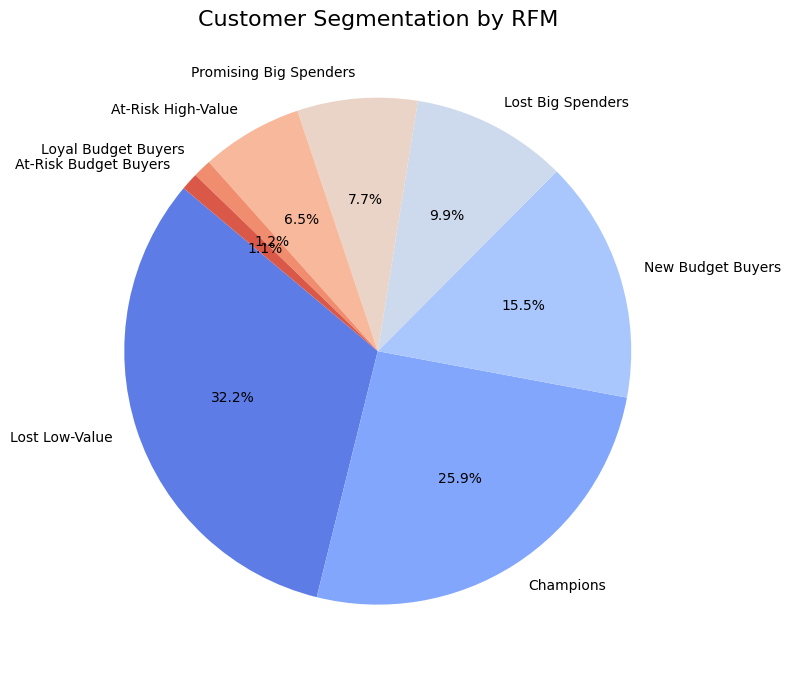

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('coolwarm', len(segment_counts)))

plt.title('Customer Segmentation by RFM', fontsize=16)

plt.tight_layout()
plt.show()

## **Maketing Strategy Recommended for each Segment**

Based on the Customer Segmentation Analysis, we will determine the most appropriate marketing strategy to effectively target and engage each group.

**Champions :**

*   Offer exclusive loyalty programs or VIP memberships, early access to products and premium experiences.
*   Launch upselling and cross-selling campaigns to encourage them to purchase premium products or complementary items.

**Promising Big Spenders:**

*   Use high-value welcome offers and bundled offers to encourage larger purchases early.
*   Send personalized thank-you messages with special discounts to strengthen their emotional connection to your brand.

**Loyal Budget Buyers :**

*   Provide volume-based discounts like "Buy 2, Get 1 Free" to encourage higher spending per transaction.
*   Offer personalized product recommendations based on their purchase history to increase average order value.

**At-Risk High-Value :**

*   Send win-back campaigns with special offers like "We Miss You! 20% Off Your Next Purchase".
*   Use email reminders about new products or services that align with their past purchases.

**Lost Big Spenders :**

*   Reach out with high-value incentives like free shipping or a significant discount to reactivate them.
*   Conduct surveys or feedback requests to understand why they stopped engaging and address their concerns.

**At-Risk Budget Buyers :**

*   Provide discounts on their favorite low-cost items to rebuild the habit.
*   Highlight new arrivals or bestsellers to reignite their interest.

**New Budget Buyers :**

*   Guide them with onboarding emails showcasing bestsellers, promotions, or usage tips.
*   Provide a welcome discount on their next purchase to encourage repeat visits.

**Lost Low-Value :**

*   Send reactivation campaigns with compelling offers like "Come Back and Get 30% Off".
*   Use retargeting ads on social media or search engines to remind them of your brand.

